# Trying some architectures

In this notebook we will try to design an architecture from a created training set.

We will after make it fit our Kaggle dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

## Toolbox
Dans cette partie on va définir les fonctions qui permettent de générer une signal artificiel.

In [2]:
def plot_series(time, series, format="-", start=0, end=None, ratio=None):
    """Simply plot the Serie"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if ratio is not None:
        plt.axvline(x=int(len(time) * (1 - ratio)))
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def split(time, serie, ratio=0.3):
    """Splits the dataset into (1 - ratio) training and (ratio) validation"""
    assert len(serie) == len(time), "Time and Serie size don't fit"
    assert 0 < ratio and ratio < 1, "Ratio should be between 0 and 1"
    split_time = math.ceil(len(time) * (1 - ratio))
    time_train, x_train = time[:split_time], series[:split_time]
    time_valid, x_valid = time[split_time:], series[split_time:]
    return time_train, x_train, time_valid, x_valid

def serieGenerator(time, baseline, amplitude, period, slope, noise_level):
    """Generates the series with all the parameters"""
    return baseline \
            + trend(time, slope) \
            + seasonality(time, period, amplitude) \
            + noise(time, noise_level, seed=42)

## Model

Dans cette partie on va définir un modèle ainsi que des méthodes pour l'entrainer et l'évaluer automatiquement.

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def modelGenerator():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
      tf.keras.layers.SimpleRNN(40, return_sequences=True),
      tf.keras.layers.SimpleRNN(40),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    return model

def historyGenerator(x_train, window_size, batch_size):
    # clear the previous session
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)
    # call the model generator
    model = modelGenerator()
    # prepare the dataset
    train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=1000)
    # create the callback
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
    # set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
    # compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    # run the training
    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
    return history

def learningRateGenerator(history, margin=0.005):
    """Use the callback to test different learning rates and choose the best one"""
    # find the best learning rate
    y = np.array(history.history["loss"])
    eps = (max(y) - min(y)) * margin
    y = (y[:-1] - y[1:]) < - eps
    x = history.history["lr"][:-1]
    x0 = np.extract(y, x)[0]
    # plot the graph to check that everything is okais
    plt.title("Loss according to the learning rate")
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axvline(x=x0)
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.axis([1e-8, 1e-4, 0, 30])
    return x0

def train(x_train, x_valid, window_size, batch_size, learning_rate, epochs):
    """Train the model with the best learning rate"""
    # clear the previous session
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)
    # call the model generator
    model = modelGenerator()
    # prepare the dataset
    train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=1000)
    val_set = windowed_dataset(x_valid, window_size, batch_size=batch_size, shuffle_buffer=1000)
    # set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    # compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    # run the training
    history = model.fit(train_set, validation_data=val_set, epochs=epochs)
    return model, history

def plotHistory(history):
    """Plot the training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Training History')
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Loss (0 - 100%)')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')
    
    start = int(len(history.history['loss']) / 2)
    ax2.plot(history.history['loss'][start:])
    ax2.plot(history.history['val_loss'][start:])
    ax2.set_title('Loss (50 - 100 %)')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    
def forecast(model, series, window_size, split_time):
    """Use the model to forecast on the valid set"""
    forecast=[]
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

## Avec un RNN

### Un signal simple

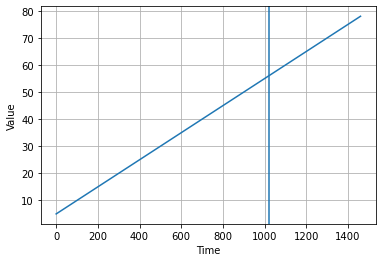

In [4]:
# Generation
time = np.arange(4 * 365 + 1, dtype="float32")
series = serieGenerator(time, baseline=5, amplitude=0, period=365, slope=0.05, noise_level=0)

# Split
ratio = 0.3
time_train, x_train, time_valid, x_valid = split(time, series, ratio)

# Plot
plot_series(time, series, ratio=ratio)

# Parameters to learn
window_size = 50
batch_size = 32

In [5]:
history_lr = historyGenerator(x_train, window_size, batch_size)

2022-01-28 15:53:00.247452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 15:53:00.278087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 15:53:00.278335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 15:53:00.278819: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100
31/31 [==============================] - 3s 47ms/step - loss: 20.1234 - mae: 20.6173 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 41ms/step - loss: 19.2838 - mae: 19.7790 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 40ms/step - loss: 18.3919 - mae: 18.8869 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 39ms/step - loss: 17.4687 - mae: 17.9638 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 42ms/step - loss: 16.4955 - mae: 16.9892 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 40ms/step - loss: 15.4497 - mae: 15.9435 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 42ms/step - loss: 14.3267 - mae: 14.8188 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 41ms/step - loss: 13.1228 - mae: 13.6146 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 41ms/step - loss: 11.8323 - mae:

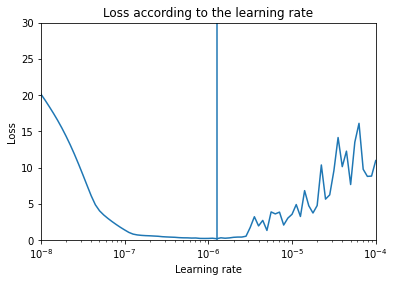

In [6]:
lr = learningRateGenerator(history_lr, margin=0.0001)

In [7]:
model, history = train(x_train, x_valid, window_size, batch_size, lr, epochs=400)

Epoch 1/400
31/31 [==============================] - 3s 61ms/step - loss: 8.2959 - mae: 8.7693 - val_loss: 11.7177 - val_mae: 12.2177
Epoch 2/400
31/31 [==============================] - 2s 51ms/step - loss: 1.2987 - mae: 1.7360 - val_loss: 14.8380 - val_mae: 15.3380
Epoch 3/400
31/31 [==============================] - 1s 46ms/step - loss: 0.8967 - mae: 1.3335 - val_loss: 13.8164 - val_mae: 14.3164
Epoch 4/400
31/31 [==============================] - 2s 49ms/step - loss: 0.6813 - mae: 1.0963 - val_loss: 11.5494 - val_mae: 12.0494
Epoch 5/400
31/31 [==============================] - 2s 55ms/step - loss: 0.5035 - mae: 0.8991 - val_loss: 11.0006 - val_mae: 11.5006
Epoch 6/400
31/31 [==============================] - 2s 61ms/step - loss: 0.3946 - mae: 0.7642 - val_loss: 10.9490 - val_mae: 11.4490
Epoch 7/400
31/31 [==============================] - 2s 50ms/step - loss: 0.4114 - mae: 0.7806 - val_loss: 9.0934 - val_mae: 9.5934
Epoch 8/400
31/31 [==============================] - 2s 48ms/ste

31/31 [==============================] - 1s 46ms/step - loss: 0.0345 - mae: 0.2051 - val_loss: 2.8067 - val_mae: 3.2914
Epoch 124/400
31/31 [==============================] - 1s 46ms/step - loss: 0.1293 - mae: 0.4182 - val_loss: 3.5299 - val_mae: 4.0299
Epoch 125/400
31/31 [==============================] - 2s 48ms/step - loss: 0.0303 - mae: 0.1959 - val_loss: 3.5030 - val_mae: 4.0030
Epoch 126/400
31/31 [==============================] - 2s 53ms/step - loss: 0.0246 - mae: 0.1756 - val_loss: 3.2367 - val_mae: 3.7362
Epoch 127/400
31/31 [==============================] - 2s 52ms/step - loss: 0.0212 - mae: 0.1610 - val_loss: 3.3738 - val_mae: 3.8738
Epoch 128/400
31/31 [==============================] - 2s 54ms/step - loss: 0.0302 - mae: 0.1946 - val_loss: 3.5634 - val_mae: 4.0634
Epoch 129/400
31/31 [==============================] - 2s 56ms/step - loss: 0.0379 - mae: 0.2125 - val_loss: 3.3301 - val_mae: 3.8301
Epoch 130/400
31/31 [==============================] - 2s 55ms/step - loss: 

31/31 [==============================] - 2s 57ms/step - loss: 0.0104 - mae: 0.1129 - val_loss: 1.9349 - val_mae: 2.4144
Epoch 246/400
31/31 [==============================] - 2s 51ms/step - loss: 0.0087 - mae: 0.1075 - val_loss: 1.9004 - val_mae: 2.3778
Epoch 247/400
31/31 [==============================] - 2s 47ms/step - loss: 0.0164 - mae: 0.1442 - val_loss: 2.1729 - val_mae: 2.6683
Epoch 248/400
31/31 [==============================] - 2s 55ms/step - loss: 0.0297 - mae: 0.1904 - val_loss: 1.4880 - val_mae: 1.8997
Epoch 249/400
31/31 [==============================] - 2s 55ms/step - loss: 0.0321 - mae: 0.2029 - val_loss: 2.2902 - val_mae: 2.7888
Epoch 250/400
31/31 [==============================] - 2s 53ms/step - loss: 0.0233 - mae: 0.1805 - val_loss: 1.8523 - val_mae: 2.3207
Epoch 251/400
31/31 [==============================] - 2s 54ms/step - loss: 0.0082 - mae: 0.1050 - val_loss: 1.8898 - val_mae: 2.3653
Epoch 252/400
31/31 [==============================] - 2s 61ms/step - loss: 

31/31 [==============================] - 2s 48ms/step - loss: 0.0041 - mae: 0.0743 - val_loss: 1.5791 - val_mae: 2.0460
Epoch 368/400
31/31 [==============================] - 2s 49ms/step - loss: 0.0015 - mae: 0.0453 - val_loss: 1.7865 - val_mae: 2.2756
Epoch 369/400
31/31 [==============================] - 2s 46ms/step - loss: 0.0069 - mae: 0.0946 - val_loss: 1.6383 - val_mae: 2.1146
Epoch 370/400
31/31 [==============================] - 2s 48ms/step - loss: 0.0028 - mae: 0.0618 - val_loss: 1.5705 - val_mae: 2.0366
Epoch 371/400
31/31 [==============================] - 2s 48ms/step - loss: 0.0024 - mae: 0.0513 - val_loss: 1.6614 - val_mae: 2.1422
Epoch 372/400
31/31 [==============================] - 2s 49ms/step - loss: 0.0019 - mae: 0.0475 - val_loss: 1.5691 - val_mae: 2.0382
Epoch 373/400
31/31 [==============================] - 2s 49ms/step - loss: 0.0024 - mae: 0.0531 - val_loss: 1.5612 - val_mae: 2.0281
Epoch 374/400
31/31 [==============================] - 2s 56ms/step - loss: 

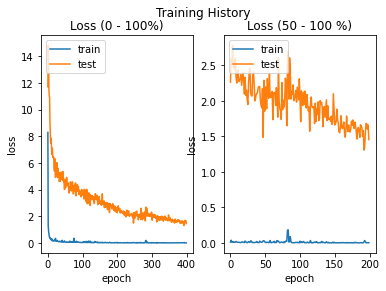

In [8]:
plotHistory(history)

In [9]:
# On fait la prédiction
split_time = math.ceil(len(time) * (1 - ratio))
results = forecast(model, series, window_size, split_time)

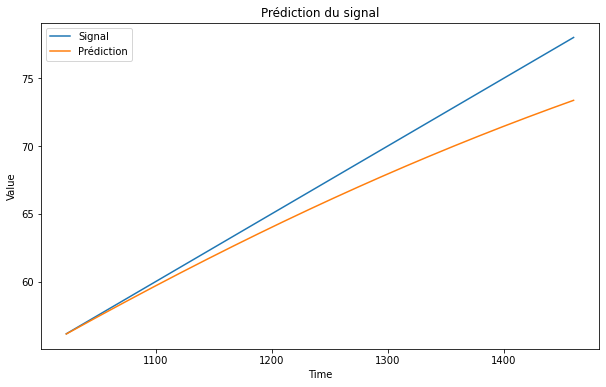

In [20]:
plt.figure(figsize=(10, 6))
plt.title("Prédiction du signal")
plt.plot(time_valid, x_valid, label="Signal")
plt.plot(time_valid, results, label="Prédiction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

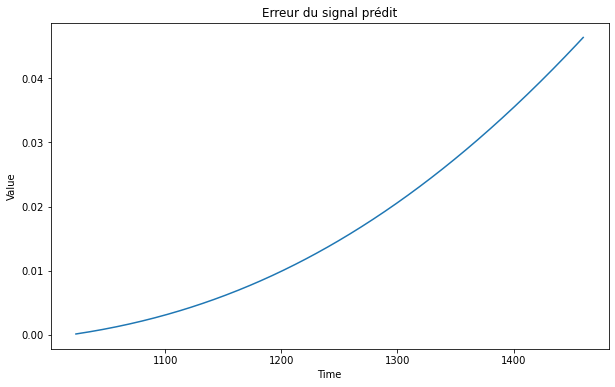

In [22]:
plt.figure(figsize=(10, 6))
plt.title("Erreur du signal prédit")
plt.xlabel("Time")
plt.ylabel("Value")
plt.plot(time_valid, np.abs(x_valid - results) / 100)
plt.show()

#### Conclusion

En conclusion, on peut voir que même pour un signal simplifié au maximum (à savoir une droite), le modèle a du mal à identifier certaines caractériques de bases comme la forme.

Le résultat n'est toutefois pas très mauvais, car la prédiction est relativement correcte avant de diverger en s'éloignant du temps connu.

### Sur un signal périodique

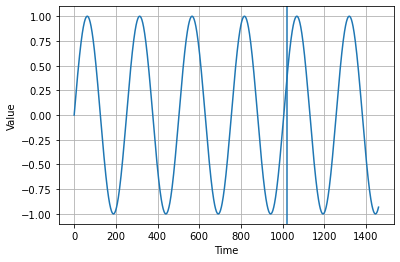

In [49]:
# Generation
time = np.arange(4 * 365 + 1, dtype="float32")
series = np.sin(time / 40)
    
# Split
ratio = 0.3
time_train, x_train, time_valid, x_valid = split(time, series, ratio)

# Plot
plot_series(time, series, ratio=ratio)

# Parameters to learn
window_size = 50
batch_size = 32

In [50]:
history_lr = historyGenerator(x_train, window_size, batch_size)

Epoch 1/100
31/31 [==============================] - 2s 40ms/step - loss: 24.2276 - mae: 24.7267 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 37ms/step - loss: 22.8092 - mae: 23.3089 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 37ms/step - loss: 21.0750 - mae: 21.5749 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 39ms/step - loss: 19.1161 - mae: 19.6151 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 41ms/step - loss: 16.8911 - mae: 17.3906 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 42ms/step - loss: 14.3684 - mae: 14.8676 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 2s 47ms/step - loss: 11.5049 - mae: 12.0039 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 39ms/step - loss: 8.2567 - mae: 8.7562 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 39ms/step - loss: 4.7464 - mae: 5.

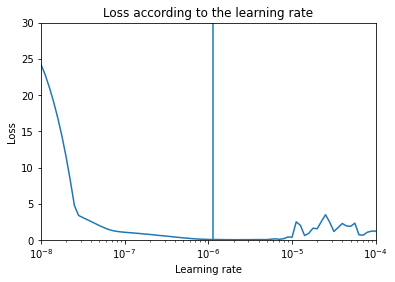

In [51]:
lr = learningRateGenerator(history_lr, margin=0.0002)

In [52]:
model_2, history = train(x_train, x_valid, window_size, batch_size, lr, epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 66ms/step - loss: 8.8191 - mae: 9.3053 - val_loss: 1.4519 - val_mae: 1.8899
Epoch 2/100
31/31 [==============================] - 2s 47ms/step - loss: 1.3945 - mae: 1.8402 - val_loss: 0.8864 - val_mae: 1.2870
Epoch 3/100
31/31 [==============================] - 2s 49ms/step - loss: 0.7620 - mae: 1.1651 - val_loss: 0.5489 - val_mae: 0.8778
Epoch 4/100
31/31 [==============================] - 2s 49ms/step - loss: 0.4676 - mae: 0.8059 - val_loss: 0.3703 - val_mae: 0.6616
Epoch 5/100
31/31 [==============================] - 2s 48ms/step - loss: 0.3104 - mae: 0.6219 - val_loss: 0.2455 - val_mae: 0.5455
Epoch 6/100
31/31 [==============================] - 2s 52ms/step - loss: 0.2086 - mae: 0.5064 - val_loss: 0.2034 - val_mae: 0.5123
Epoch 7/100
31/31 [==============================] - 2s 54ms/step - loss: 0.1647 - mae: 0.4644 - val_loss: 0.1634 - val_mae: 0.4583
Epoch 8/100
31/31 [==============================] - 2s 54ms/step - loss: 0.

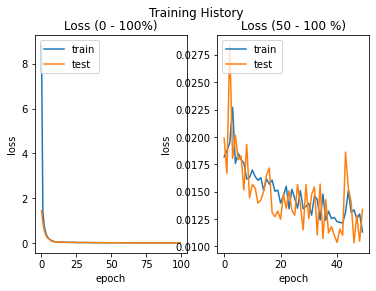

In [53]:
plotHistory(history)

In [54]:
# On fait la prédiction
split_time = math.ceil(len(time) * (1 - ratio))
results = forecast(model, series, window_size, split_time)

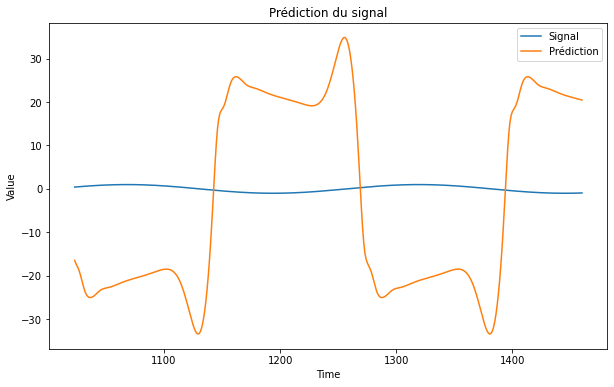

In [56]:
plt.figure(figsize=(10, 6))
plt.title("Prédiction du signal")
plt.plot(time_valid, x_valid, label="Signal")
plt.plot(time_valid, results, label="Prédiction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

Text(0, 0.5, 'Value')

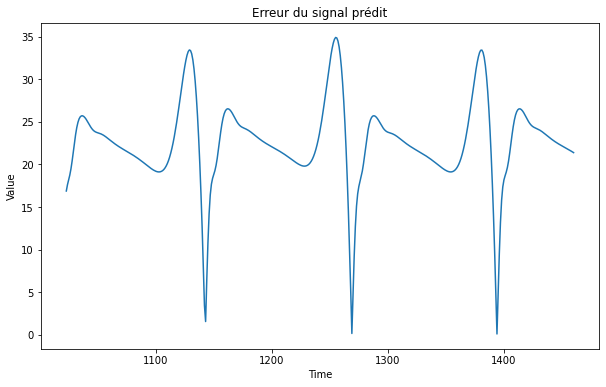

In [57]:
plt.figure(figsize=(10, 6))
plt.title("Erreur du signal prédit")
plt.plot(time_valid, np.abs(x_valid - results))
plt.xlabel("Time")
plt.ylabel("Value")

#### Conclusion

On peut voir que le réseau a bien appris une forme de périodicité. En revanche le résultat est plus que médiocre.

Dans cette partie une nouvelle question se pose sur la taille de la fenêtre à utiliser. Avant d'étudier les meilleurs valeurs à utiliser, nous allons améliorer le modèle.

## Avec des couches LSTM

### Avec un signal simple (et LSTM Bidirectionnel)

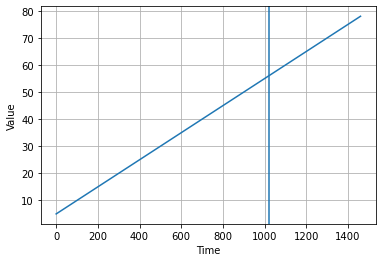

In [24]:
# Generation
time = np.arange(4 * 365 + 1, dtype="float32")
series = serieGenerator(time, baseline=5, amplitude=0, period=365, slope=0.05, noise_level=0)

# Split
ratio = 0.3
time_train, x_train, time_valid, x_valid = split(time, series, ratio)

# Plot
plot_series(time, series, ratio=ratio)

# Parameters to learn
window_size = 50
batch_size = 32

In [25]:
def modelGenerator():    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
      tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
      tf.keras.layers.LSTM(100, return_sequences=True),
      tf.keras.layers.LSTM(100),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    return model

modelGenerator().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, None, 1)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          128       
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         53200     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 lambda_3 (Lambda)           (None, 100)               0         
                                                                 
Total params: 143,828
Trainable params: 143,828
Non-tr

In [26]:
history_lr = historyGenerator(x_train, window_size, batch_size)

Epoch 1/100
31/31 [==============================] - 2s 8ms/step - loss: 32.0928 - mae: 32.5895 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 31.8962 - mae: 32.3927 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 31.6846 - mae: 32.1810 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 31.5600 - mae: 32.0559 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 31.4938 - mae: 31.9893 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 31.4416 - mae: 31.9371 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 31.3903 - mae: 31.8860 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 31.3350 - mae: 31.8309 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 31.2722 - mae: 31.7684 

31/31 [==============================] - 0s 6ms/step - loss: 1.8519 - mae: 2.2982 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 6ms/step - loss: 1.4522 - mae: 1.8887 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 6ms/step - loss: 1.4423 - mae: 1.8820 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 6ms/step - loss: 1.3491 - mae: 1.7770 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 6ms/step - loss: 1.5500 - mae: 1.9869 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 6ms/step - loss: 0.6089 - mae: 0.9926 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 6ms/step - loss: 0.5906 - mae: 0.9742 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 6ms/step - loss: 1.0868 - mae: 1.5133 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 6ms/step - loss: 0.9258 - mae: 1.3379 - lr: 1.0000e-04
Epoch

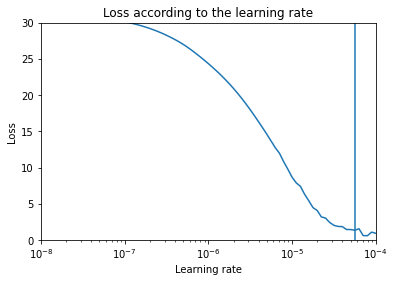

In [27]:
lr = learningRateGenerator(history_lr)

In [28]:
model_3, history_3 = train(x_train, x_valid, window_size, batch_size, lr, epochs=400)

Epoch 1/400
31/31 [==============================] - 3s 26ms/step - loss: 23.4036 - mae: 23.8986 - val_loss: 46.1391 - val_mae: 46.6391
Epoch 2/400
31/31 [==============================] - 0s 9ms/step - loss: 13.0256 - mae: 13.5146 - val_loss: 35.7800 - val_mae: 36.2800
Epoch 3/400
31/31 [==============================] - 0s 9ms/step - loss: 8.3641 - mae: 8.8467 - val_loss: 28.2797 - val_mae: 28.7797
Epoch 4/400
31/31 [==============================] - 0s 8ms/step - loss: 5.4878 - mae: 5.9654 - val_loss: 23.0345 - val_mae: 23.5345
Epoch 5/400
31/31 [==============================] - 0s 9ms/step - loss: 3.5716 - mae: 4.0379 - val_loss: 19.1309 - val_mae: 19.6309
Epoch 6/400
31/31 [==============================] - 0s 8ms/step - loss: 2.3710 - mae: 2.8165 - val_loss: 16.1140 - val_mae: 16.6140
Epoch 7/400
31/31 [==============================] - 0s 8ms/step - loss: 2.0758 - mae: 2.5212 - val_loss: 15.0129 - val_mae: 15.5129
Epoch 8/400
31/31 [==============================] - 0s 8ms/step

Epoch 63/400
31/31 [==============================] - 0s 8ms/step - loss: 0.0319 - mae: 0.1954 - val_loss: 4.9481 - val_mae: 5.4459
Epoch 64/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0207 - mae: 0.1549 - val_loss: 4.9381 - val_mae: 5.4365
Epoch 65/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0287 - mae: 0.1850 - val_loss: 4.4631 - val_mae: 4.9458
Epoch 66/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1001 - mae: 0.3625 - val_loss: 4.6209 - val_mae: 5.1102
Epoch 67/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1463 - mae: 0.4331 - val_loss: 5.2979 - val_mae: 5.7974
Epoch 68/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0451 - mae: 0.2270 - val_loss: 5.1012 - val_mae: 5.6006
Epoch 69/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0261 - mae: 0.1751 - val_loss: 4.8972 - val_mae: 5.3951
Epoch 70/400
31/31 [==============================] - 0s 9ms/step - loss: 0.

Epoch 125/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0166 - mae: 0.1411 - val_loss: 3.9714 - val_mae: 4.4632
Epoch 126/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0115 - mae: 0.1172 - val_loss: 3.8525 - val_mae: 4.3379
Epoch 127/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0283 - mae: 0.1923 - val_loss: 3.8972 - val_mae: 4.3846
Epoch 128/400
31/31 [==============================] - 0s 8ms/step - loss: 0.0142 - mae: 0.1297 - val_loss: 4.1385 - val_mae: 4.6362
Epoch 129/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0219 - mae: 0.1636 - val_loss: 3.9345 - val_mae: 4.4259
Epoch 130/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0083 - mae: 0.0995 - val_loss: 3.9944 - val_mae: 4.4890
Epoch 131/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0094 - mae: 0.1056 - val_loss: 3.8623 - val_mae: 4.3518
Epoch 132/400
31/31 [==============================] - 0s 8ms/step - 

31/31 [==============================] - 0s 9ms/step - loss: 0.0066 - mae: 0.0897 - val_loss: 3.3655 - val_mae: 3.8405
Epoch 187/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0107 - mae: 0.1175 - val_loss: 3.4902 - val_mae: 3.9766
Epoch 188/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0084 - mae: 0.1001 - val_loss: 3.2937 - val_mae: 3.7615
Epoch 189/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0110 - mae: 0.1178 - val_loss: 3.5007 - val_mae: 3.9878
Epoch 190/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0068 - mae: 0.0891 - val_loss: 3.4465 - val_mae: 3.9306
Epoch 191/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0067 - mae: 0.0916 - val_loss: 3.6156 - val_mae: 4.1099
Epoch 192/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0090 - mae: 0.1049 - val_loss: 3.5494 - val_mae: 4.0408
Epoch 193/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0094 -

Epoch 248/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0053 - mae: 0.0797 - val_loss: 3.1746 - val_mae: 3.6540
Epoch 249/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0157 - mae: 0.1408 - val_loss: 3.1661 - val_mae: 3.6442
Epoch 250/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0090 - mae: 0.1024 - val_loss: 3.2793 - val_mae: 3.7666
Epoch 251/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0078 - mae: 0.0980 - val_loss: 3.3269 - val_mae: 3.8173
Epoch 252/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0060 - mae: 0.0856 - val_loss: 3.0461 - val_mae: 3.5115
Epoch 253/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0413 - mae: 0.2271 - val_loss: 3.5699 - val_mae: 4.0685
Epoch 254/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0116 - mae: 0.1190 - val_loss: 3.2509 - val_mae: 3.7363
Epoch 255/400
31/31 [==============================] - 0s 9ms/step - 

31/31 [==============================] - 0s 9ms/step - loss: 0.0092 - mae: 0.1052 - val_loss: 2.9994 - val_mae: 3.4737
Epoch 310/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0041 - mae: 0.0713 - val_loss: 3.1375 - val_mae: 3.6264
Epoch 311/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0078 - mae: 0.0969 - val_loss: 3.0914 - val_mae: 3.5767
Epoch 312/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0046 - mae: 0.0753 - val_loss: 3.0494 - val_mae: 3.5310
Epoch 313/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0044 - mae: 0.0711 - val_loss: 3.1384 - val_mae: 3.6284
Epoch 314/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0055 - mae: 0.0837 - val_loss: 2.9668 - val_mae: 3.4407
Epoch 315/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0196 - mae: 0.1526 - val_loss: 2.8371 - val_mae: 3.2956
Epoch 316/400
31/31 [==============================] - 0s 8ms/step - loss: 0.0082 -

Epoch 371/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0554 - val_loss: 2.8790 - val_mae: 3.3512
Epoch 372/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0027 - mae: 0.0572 - val_loss: 2.9442 - val_mae: 3.4247
Epoch 373/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0078 - mae: 0.0939 - val_loss: 2.9730 - val_mae: 3.4567
Epoch 374/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0043 - mae: 0.0731 - val_loss: 2.9558 - val_mae: 3.4377
Epoch 375/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0066 - mae: 0.0911 - val_loss: 2.8147 - val_mae: 3.2797
Epoch 376/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0071 - mae: 0.0956 - val_loss: 3.0794 - val_mae: 3.5717
Epoch 377/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0055 - mae: 0.0798 - val_loss: 2.8608 - val_mae: 3.3323
Epoch 378/400
31/31 [==============================] - 0s 9ms/step - 

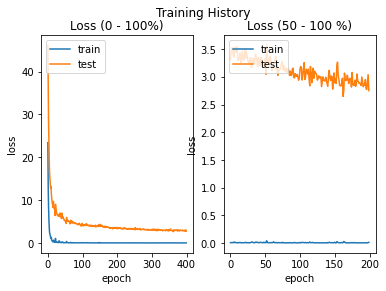

In [29]:
plotHistory(history_3)

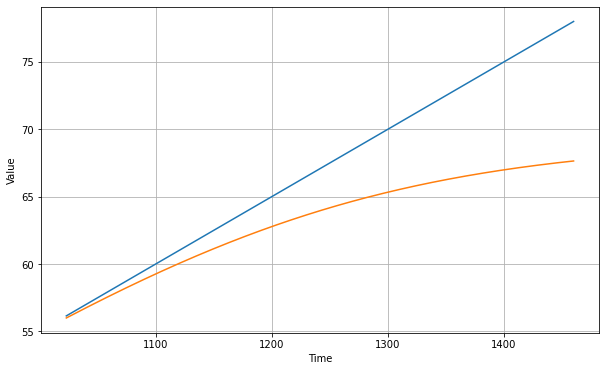

In [30]:
# Plot la prédiction
split_time = math.ceil(len(time) * (1 - ratio))
results = forecast(model_3, series, window_size, split_time)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

#### Conclusion

On a une prédiction un peu décevante sur ce signal. Le modèle diverge énormément.

### Sur un signal périodique

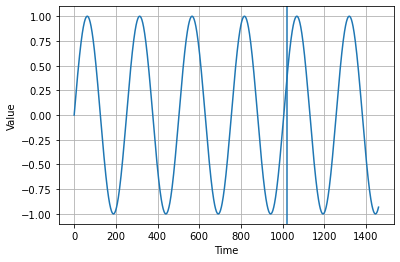

In [13]:
# Generation
time = np.arange(4 * 365 + 1, dtype="float32")
series = np.sin(time / 40)
    
# Split
ratio = 0.3
time_train, x_train, time_valid, x_valid = split(time, series, ratio)

# Plot
plot_series(time, series, ratio=ratio)

# Parameters to learn
window_size = 50
batch_size = 32

In [14]:
def modelGenerator():    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
      tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
      tf.keras.layers.LSTM(100, return_sequences=True),
      tf.keras.layers.LSTM(100),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    return model

modelGenerator().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, None, 1)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          128       
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         53200     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 lambda_3 (Lambda)           (None, 100)               0         
                                                                 
Total params: 143,828
Trainable params: 143,828
Non-tr

In [15]:
history_lr = historyGenerator(x_train, window_size, batch_size)

Epoch 1/100
31/31 [==============================] - 2s 10ms/step - loss: 1.8807 - mae: 2.3166 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 1.8798 - mae: 2.3157 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 1.8788 - mae: 2.3146 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 1.8776 - mae: 2.3133 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 1.8763 - mae: 2.3119 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 1.8748 - mae: 2.3103 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 1.8731 - mae: 2.3085 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 1.8713 - mae: 2.3065 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 1.8692 - mae: 2.3042 - lr: 2.5119e-08


31/31 [==============================] - 0s 6ms/step - loss: 0.2696 - mae: 0.5788 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2473 - mae: 0.5508 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2262 - mae: 0.5239 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2068 - mae: 0.4988 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1885 - mae: 0.4735 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1715 - mae: 0.4506 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1556 - mae: 0.4274 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1408 - mae: 0.4051 - lr: 1.0000e-04
Epoch 82/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1272 - mae: 0.3850 - lr: 1.1220e-04
Epoch

In [20]:
#lr = learningRateGenerator(history_lr)
lr = 10e-4

In [21]:
model_4, history_4 = train(x_train, x_valid, window_size, batch_size, lr, epochs=400)

Epoch 1/400
31/31 [==============================] - 3s 27ms/step - loss: 0.6126 - mae: 0.9783 - val_loss: 0.1908 - val_mae: 0.4859
Epoch 2/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1227 - mae: 0.3817 - val_loss: 0.0826 - val_mae: 0.3158
Epoch 3/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0622 - mae: 0.2730 - val_loss: 0.0473 - val_mae: 0.2414
Epoch 4/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0384 - mae: 0.2175 - val_loss: 0.0297 - val_mae: 0.1940
Epoch 5/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0260 - mae: 0.1815 - val_loss: 0.0244 - val_mae: 0.1753
Epoch 6/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0192 - mae: 0.1557 - val_loss: 0.0159 - val_mae: 0.1401
Epoch 7/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0151 - mae: 0.1369 - val_loss: 0.0136 - val_mae: 0.1307
Epoch 8/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0131 - 

31/31 [==============================] - 0s 9ms/step - loss: 0.0021 - mae: 0.0487 - val_loss: 0.0021 - val_mae: 0.0494
Epoch 64/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0020 - mae: 0.0484 - val_loss: 0.0019 - val_mae: 0.0469
Epoch 65/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0020 - mae: 0.0476 - val_loss: 0.0018 - val_mae: 0.0450
Epoch 66/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0019 - mae: 0.0473 - val_loss: 0.0018 - val_mae: 0.0451
Epoch 67/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0019 - mae: 0.0468 - val_loss: 0.0017 - val_mae: 0.0445
Epoch 68/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0019 - mae: 0.0469 - val_loss: 0.0020 - val_mae: 0.0475
Epoch 69/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - mae: 0.0458 - val_loss: 0.0017 - val_mae: 0.0442
Epoch 70/400
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - mae: 0

31/31 [==============================] - 0s 9ms/step - loss: 8.3459e-04 - mae: 0.0302 - val_loss: 8.5685e-04 - val_mae: 0.0305
Epoch 125/400
31/31 [==============================] - 0s 9ms/step - loss: 8.2338e-04 - mae: 0.0300 - val_loss: 8.3762e-04 - val_mae: 0.0303
Epoch 126/400
31/31 [==============================] - 0s 9ms/step - loss: 8.2163e-04 - mae: 0.0299 - val_loss: 8.9175e-04 - val_mae: 0.0312
Epoch 127/400
31/31 [==============================] - 0s 9ms/step - loss: 8.2239e-04 - mae: 0.0299 - val_loss: 8.5118e-04 - val_mae: 0.0304
Epoch 128/400
31/31 [==============================] - 0s 9ms/step - loss: 8.0607e-04 - mae: 0.0296 - val_loss: 7.2754e-04 - val_mae: 0.0278
Epoch 129/400
31/31 [==============================] - 0s 9ms/step - loss: 7.8894e-04 - mae: 0.0293 - val_loss: 7.5929e-04 - val_mae: 0.0288
Epoch 130/400
31/31 [==============================] - 0s 9ms/step - loss: 7.8355e-04 - mae: 0.0291 - val_loss: 7.8001e-04 - val_mae: 0.0289
Epoch 131/400
31/31 [======

31/31 [==============================] - 0s 9ms/step - loss: 4.7510e-04 - mae: 0.0227 - val_loss: 4.4370e-04 - val_mae: 0.0219
Epoch 183/400
31/31 [==============================] - 0s 9ms/step - loss: 4.6506e-04 - mae: 0.0225 - val_loss: 4.2726e-04 - val_mae: 0.0216
Epoch 184/400
31/31 [==============================] - 0s 9ms/step - loss: 4.5312e-04 - mae: 0.0222 - val_loss: 4.2441e-04 - val_mae: 0.0215
Epoch 185/400
31/31 [==============================] - 0s 9ms/step - loss: 4.5368e-04 - mae: 0.0222 - val_loss: 4.4072e-04 - val_mae: 0.0224
Epoch 186/400
31/31 [==============================] - 0s 9ms/step - loss: 4.5325e-04 - mae: 0.0223 - val_loss: 4.3517e-04 - val_mae: 0.0216
Epoch 187/400
31/31 [==============================] - 0s 9ms/step - loss: 4.4986e-04 - mae: 0.0222 - val_loss: 4.7646e-04 - val_mae: 0.0226
Epoch 188/400
31/31 [==============================] - 0s 9ms/step - loss: 4.4511e-04 - mae: 0.0220 - val_loss: 4.2957e-04 - val_mae: 0.0217
Epoch 189/400
31/31 [======

31/31 [==============================] - 0s 9ms/step - loss: 2.9466e-04 - mae: 0.0181 - val_loss: 2.8141e-04 - val_mae: 0.0175
Epoch 241/400
31/31 [==============================] - 0s 9ms/step - loss: 2.9277e-04 - mae: 0.0179 - val_loss: 2.7908e-04 - val_mae: 0.0175
Epoch 242/400
31/31 [==============================] - 0s 9ms/step - loss: 2.9251e-04 - mae: 0.0180 - val_loss: 2.8076e-04 - val_mae: 0.0176
Epoch 243/400
31/31 [==============================] - 0s 9ms/step - loss: 2.9078e-04 - mae: 0.0179 - val_loss: 2.6946e-04 - val_mae: 0.0173
Epoch 244/400
31/31 [==============================] - 0s 9ms/step - loss: 2.8813e-04 - mae: 0.0178 - val_loss: 2.7723e-04 - val_mae: 0.0175
Epoch 245/400
31/31 [==============================] - 0s 9ms/step - loss: 2.8877e-04 - mae: 0.0179 - val_loss: 2.6680e-04 - val_mae: 0.0172
Epoch 246/400
31/31 [==============================] - 0s 9ms/step - loss: 2.8368e-04 - mae: 0.0177 - val_loss: 2.7232e-04 - val_mae: 0.0176
Epoch 247/400
31/31 [======

31/31 [==============================] - 0s 9ms/step - loss: 2.0685e-04 - mae: 0.0152 - val_loss: 1.8982e-04 - val_mae: 0.0145
Epoch 299/400
31/31 [==============================] - 0s 9ms/step - loss: 2.0688e-04 - mae: 0.0152 - val_loss: 1.9823e-04 - val_mae: 0.0149
Epoch 300/400
31/31 [==============================] - 0s 8ms/step - loss: 2.0362e-04 - mae: 0.0150 - val_loss: 1.9846e-04 - val_mae: 0.0149
Epoch 301/400
31/31 [==============================] - 0s 9ms/step - loss: 2.0511e-04 - mae: 0.0152 - val_loss: 1.9982e-04 - val_mae: 0.0151
Epoch 302/400
31/31 [==============================] - 0s 9ms/step - loss: 2.0215e-04 - mae: 0.0150 - val_loss: 1.8883e-04 - val_mae: 0.0146
Epoch 303/400
31/31 [==============================] - 0s 9ms/step - loss: 2.0212e-04 - mae: 0.0150 - val_loss: 2.0156e-04 - val_mae: 0.0150
Epoch 304/400
31/31 [==============================] - 0s 9ms/step - loss: 1.9919e-04 - mae: 0.0149 - val_loss: 1.9518e-04 - val_mae: 0.0148
Epoch 305/400
31/31 [======

31/31 [==============================] - 0s 9ms/step - loss: 1.5545e-04 - mae: 0.0132 - val_loss: 1.5417e-04 - val_mae: 0.0132
Epoch 357/400
31/31 [==============================] - 0s 10ms/step - loss: 1.5422e-04 - mae: 0.0132 - val_loss: 1.4694e-04 - val_mae: 0.0128
Epoch 358/400
31/31 [==============================] - 0s 9ms/step - loss: 1.5326e-04 - mae: 0.0131 - val_loss: 1.5302e-04 - val_mae: 0.0132
Epoch 359/400
31/31 [==============================] - 0s 9ms/step - loss: 1.5416e-04 - mae: 0.0132 - val_loss: 1.5579e-04 - val_mae: 0.0132
Epoch 360/400
31/31 [==============================] - 0s 9ms/step - loss: 1.5329e-04 - mae: 0.0131 - val_loss: 1.4490e-04 - val_mae: 0.0128
Epoch 361/400
31/31 [==============================] - 0s 9ms/step - loss: 1.5106e-04 - mae: 0.0130 - val_loss: 1.4799e-04 - val_mae: 0.0130
Epoch 362/400
31/31 [==============================] - 0s 9ms/step - loss: 1.5082e-04 - mae: 0.0130 - val_loss: 1.4713e-04 - val_mae: 0.0129
Epoch 363/400
31/31 [=====

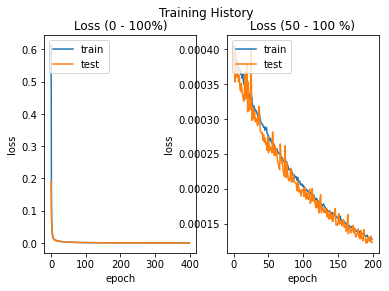

In [22]:
plotHistory(history_4)

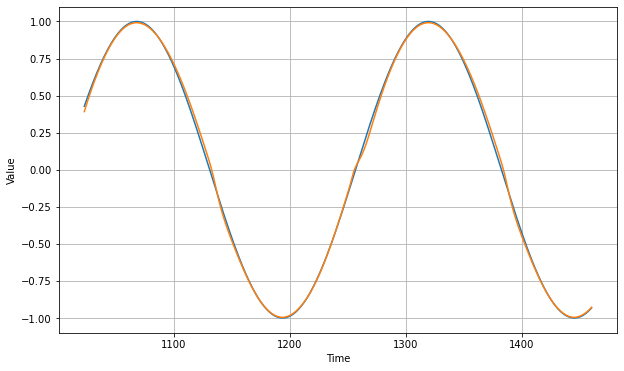

In [23]:
# Plot la prédiction
split_time = math.ceil(len(time) * (1 - ratio))
results = forecast(model_4, series, window_size, split_time)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

#### Concluion

On peut voir ici que la périodicité est très efficacement prédite par le réseaux.

### Sur un signal un peu plus complexe

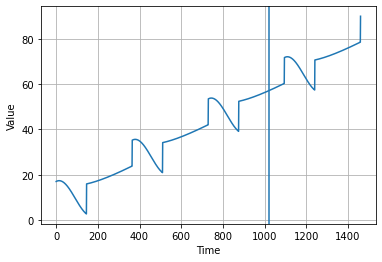

In [41]:
# Generation
time = np.arange(4 * 365 + 1, dtype="float32")
series = serieGenerator(time, baseline=5, amplitude=12, period=365, slope=0.05, noise_level=0)

# Split
ratio = 0.3
time_train, x_train, time_valid, x_valid = split(time, series, ratio)

# Plot
plot_series(time, series, ratio=ratio)

# Parameters to learn
window_size = 50
batch_size = 32

In [42]:
history_lr = historyGenerator(x_train, window_size, batch_size)

Epoch 1/100
31/31 [==============================] - 2s 8ms/step - loss: 33.8377 - mae: 34.3338 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 33.5920 - mae: 34.0882 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 33.3517 - mae: 33.8479 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 33.2396 - mae: 33.7356 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 33.1811 - mae: 33.6771 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 33.1322 - mae: 33.6283 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 33.0830 - mae: 33.5791 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 33.0297 - mae: 33.5258 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 32.9699 - mae: 33.4661 

31/31 [==============================] - 0s 6ms/step - loss: 2.3000 - mae: 2.7538 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 6ms/step - loss: 1.9709 - mae: 2.4183 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 6ms/step - loss: 1.6701 - mae: 2.1074 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 6ms/step - loss: 1.5599 - mae: 1.9941 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 6ms/step - loss: 1.9070 - mae: 2.3502 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 6ms/step - loss: 1.6509 - mae: 2.0872 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 6ms/step - loss: 1.1609 - mae: 1.5743 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 6ms/step - loss: 1.6759 - mae: 2.1184 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 6ms/step - loss: 1.5265 - mae: 1.9671 - lr: 1.0000e-04
Epoch

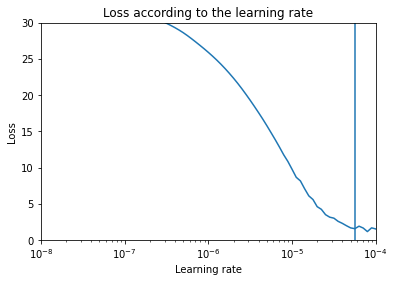

In [43]:
lr = learningRateGenerator(history_lr)

In [44]:
model_5, history_5 = train(x_train, x_valid, window_size, batch_size, lr, epochs=400)

Epoch 1/400
31/31 [==============================] - 3s 26ms/step - loss: 24.8174 - mae: 25.3125 - val_loss: 47.5093 - val_mae: 48.0093
Epoch 2/400
31/31 [==============================] - 0s 10ms/step - loss: 14.2531 - mae: 14.7443 - val_loss: 37.1940 - val_mae: 37.6940
Epoch 3/400
31/31 [==============================] - 0s 9ms/step - loss: 9.0470 - mae: 9.5305 - val_loss: 29.3253 - val_mae: 29.8253
Epoch 4/400
31/31 [==============================] - 0s 9ms/step - loss: 6.1117 - mae: 6.5885 - val_loss: 23.8274 - val_mae: 24.3273
Epoch 5/400
31/31 [==============================] - 0s 9ms/step - loss: 4.2874 - mae: 4.7565 - val_loss: 19.6101 - val_mae: 20.1098
Epoch 6/400
31/31 [==============================] - 0s 9ms/step - loss: 3.0400 - mae: 3.4958 - val_loss: 15.6900 - val_mae: 16.1875
Epoch 7/400
31/31 [==============================] - 0s 9ms/step - loss: 2.5767 - mae: 3.0321 - val_loss: 14.7127 - val_mae: 15.2120
Epoch 8/400
31/31 [==============================] - 0s 9ms/ste

Epoch 63/400
31/31 [==============================] - 0s 9ms/step - loss: 0.3289 - mae: 0.6318 - val_loss: 5.8477 - val_mae: 6.3452
Epoch 64/400
31/31 [==============================] - 0s 9ms/step - loss: 0.2743 - mae: 0.5426 - val_loss: 6.2711 - val_mae: 6.7710
Epoch 65/400
31/31 [==============================] - 0s 9ms/step - loss: 0.3837 - mae: 0.7187 - val_loss: 5.6899 - val_mae: 6.1827
Epoch 66/400
31/31 [==============================] - 0s 9ms/step - loss: 0.2975 - mae: 0.5849 - val_loss: 4.9066 - val_mae: 5.3729
Epoch 67/400
31/31 [==============================] - 0s 9ms/step - loss: 0.4848 - mae: 0.8408 - val_loss: 6.7132 - val_mae: 7.2132
Epoch 68/400
31/31 [==============================] - 0s 10ms/step - loss: 0.7027 - mae: 1.1223 - val_loss: 5.6160 - val_mae: 6.0926
Epoch 69/400
31/31 [==============================] - 0s 9ms/step - loss: 0.4104 - mae: 0.7551 - val_loss: 6.2771 - val_mae: 6.7741
Epoch 70/400
31/31 [==============================] - 0s 9ms/step - loss: 0

Epoch 125/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1783 - mae: 0.3919 - val_loss: 4.6191 - val_mae: 5.1106
Epoch 126/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1928 - mae: 0.4246 - val_loss: 3.9476 - val_mae: 4.4038
Epoch 127/400
31/31 [==============================] - 0s 9ms/step - loss: 0.2034 - mae: 0.4454 - val_loss: 4.4766 - val_mae: 4.9618
Epoch 128/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1904 - mae: 0.4153 - val_loss: 5.1553 - val_mae: 5.6553
Epoch 129/400
31/31 [==============================] - 0s 9ms/step - loss: 0.2843 - mae: 0.5874 - val_loss: 4.4405 - val_mae: 4.9209
Epoch 130/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1589 - mae: 0.3416 - val_loss: 4.5795 - val_mae: 5.0699
Epoch 131/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1655 - mae: 0.3628 - val_loss: 3.9677 - val_mae: 4.4238
Epoch 132/400
31/31 [==============================] - 0s 9ms/step - 

31/31 [==============================] - 0s 9ms/step - loss: 0.1490 - mae: 0.3453 - val_loss: 3.7450 - val_mae: 4.2144
Epoch 187/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1554 - mae: 0.3624 - val_loss: 3.9540 - val_mae: 4.4424
Epoch 188/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1358 - mae: 0.3007 - val_loss: 3.2757 - val_mae: 3.7282
Epoch 189/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1571 - mae: 0.3655 - val_loss: 3.8009 - val_mae: 4.2795
Epoch 190/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1308 - mae: 0.2880 - val_loss: 3.5355 - val_mae: 3.9920
Epoch 191/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1308 - mae: 0.2878 - val_loss: 3.8612 - val_mae: 4.3466
Epoch 192/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1399 - mae: 0.3165 - val_loss: 3.7052 - val_mae: 4.1801
Epoch 193/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1374 -

Epoch 248/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1315 - mae: 0.3136 - val_loss: 3.6207 - val_mae: 4.1106
Epoch 249/400
31/31 [==============================] - 0s 8ms/step - loss: 0.1248 - mae: 0.2800 - val_loss: 3.3446 - val_mae: 3.8117
Epoch 250/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1166 - mae: 0.2543 - val_loss: 3.1766 - val_mae: 3.6296
Epoch 251/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1159 - mae: 0.2494 - val_loss: 3.3449 - val_mae: 3.8166
Epoch 252/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1158 - mae: 0.2501 - val_loss: 2.9636 - val_mae: 3.4084
Epoch 253/400
31/31 [==============================] - 0s 8ms/step - loss: 0.1323 - mae: 0.3045 - val_loss: 3.3029 - val_mae: 3.7719
Epoch 254/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1161 - mae: 0.2515 - val_loss: 3.4711 - val_mae: 3.9570
Epoch 255/400
31/31 [==============================] - 0s 9ms/step - 

31/31 [==============================] - 0s 9ms/step - loss: 0.1166 - mae: 0.2684 - val_loss: 3.0873 - val_mae: 3.5496
Epoch 310/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1128 - mae: 0.2569 - val_loss: 3.3335 - val_mae: 3.8200
Epoch 311/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1179 - mae: 0.2763 - val_loss: 3.0117 - val_mae: 3.4674
Epoch 312/400
31/31 [==============================] - 0s 8ms/step - loss: 0.1245 - mae: 0.2965 - val_loss: 3.6025 - val_mae: 4.1008
Epoch 313/400
31/31 [==============================] - 0s 9ms/step - loss: 0.2350 - mae: 0.5454 - val_loss: 2.9555 - val_mae: 3.4024
Epoch 314/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1353 - mae: 0.3059 - val_loss: 3.0884 - val_mae: 3.5454
Epoch 315/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1306 - mae: 0.3249 - val_loss: 3.1754 - val_mae: 3.6421
Epoch 316/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1129 -

31/31 [==============================] - 0s 9ms/step - loss: 0.1266 - mae: 0.3168 - val_loss: 3.0891 - val_mae: 3.5748
Epoch 371/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1096 - mae: 0.2556 - val_loss: 2.8924 - val_mae: 3.3565
Epoch 372/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1028 - mae: 0.2243 - val_loss: 2.9524 - val_mae: 3.4248
Epoch 373/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1036 - mae: 0.2283 - val_loss: 2.8280 - val_mae: 3.2861
Epoch 374/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1002 - mae: 0.2100 - val_loss: 2.8395 - val_mae: 3.2999
Epoch 375/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1069 - mae: 0.2457 - val_loss: 2.5500 - val_mae: 2.9884
Epoch 376/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1165 - mae: 0.2838 - val_loss: 2.7248 - val_mae: 3.1731
Epoch 377/400
31/31 [==============================] - 0s 9ms/step - loss: 0.1052 -

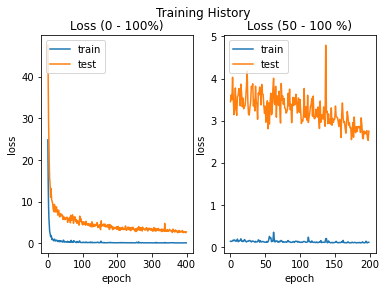

In [45]:
plotHistory(history_5)

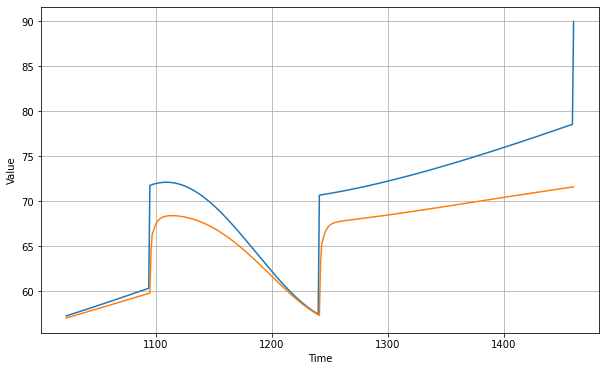

In [46]:
# Plot la prédiction
split_time = math.ceil(len(time) * (1 - ratio))
results = forecast(model_5, series, window_size, split_time)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

#### Conclusion

On se retrouve avec le même problème que précédemment : la périodicité est bien reconnue, mais le coefficient directeur de la droite ne l'est pas

### ... Avec un peu de bruit

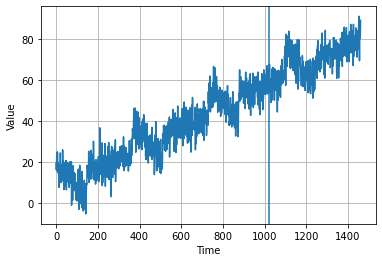

In [49]:
# Generation
time = np.arange(4 * 365 + 1, dtype="float32")
series = serieGenerator(time, baseline=5, amplitude=12, period=365, slope=0.05, noise_level=5)

# Split
ratio = 0.3
time_train, x_train, time_valid, x_valid = split(time, series, ratio)

# Plot
plot_series(time, series, ratio=ratio)

# Parameters to learn
window_size = 50
batch_size = 32

In [50]:
history_lr = historyGenerator(x_train, window_size, batch_size)

Epoch 1/100
31/31 [==============================] - 2s 8ms/step - loss: 34.3577 - mae: 34.8547 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 34.1753 - mae: 34.6724 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 33.8855 - mae: 34.3826 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 33.6754 - mae: 34.1725 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 33.5804 - mae: 34.0774 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 33.5137 - mae: 34.0107 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 33.4509 - mae: 33.9479 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 33.3853 - mae: 33.8823 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 33.3134 - mae: 33.8105 

31/31 [==============================] - 0s 7ms/step - loss: 5.3553 - mae: 5.8374 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 6ms/step - loss: 5.3501 - mae: 5.8317 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 6ms/step - loss: 4.8173 - mae: 5.2965 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 6ms/step - loss: 4.4772 - mae: 4.9563 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 6ms/step - loss: 4.4421 - mae: 4.9200 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 6ms/step - loss: 4.3960 - mae: 4.8753 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 6ms/step - loss: 4.4389 - mae: 4.9166 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 6ms/step - loss: 4.8555 - mae: 5.3364 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 6ms/step - loss: 4.2807 - mae: 4.7590 - lr: 1.0000e-04
Epoch

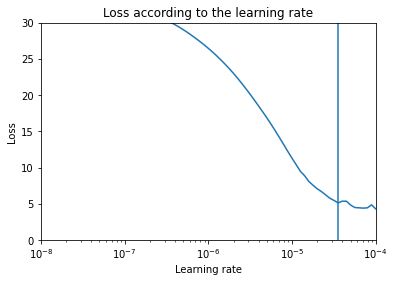

In [51]:
lr = learningRateGenerator(history_lr)

In [52]:
model_6, history_6 = train(x_train, x_valid, window_size, batch_size, lr, epochs=400)

Epoch 1/400
31/31 [==============================] - 3s 27ms/step - loss: 27.0652 - mae: 27.5609 - val_loss: 52.0546 - val_mae: 52.5546
Epoch 2/400
31/31 [==============================] - 0s 9ms/step - loss: 17.9604 - mae: 18.4538 - val_loss: 43.5201 - val_mae: 44.0201
Epoch 3/400
31/31 [==============================] - 0s 9ms/step - loss: 13.6448 - mae: 14.1367 - val_loss: 37.5801 - val_mae: 38.0801
Epoch 4/400
31/31 [==============================] - 0s 9ms/step - loss: 10.8637 - mae: 11.3531 - val_loss: 32.5975 - val_mae: 33.0974
Epoch 5/400
31/31 [==============================] - 0s 9ms/step - loss: 8.6690 - mae: 9.1559 - val_loss: 28.2773 - val_mae: 28.7771
Epoch 6/400
31/31 [==============================] - 0s 9ms/step - loss: 7.2825 - mae: 7.7675 - val_loss: 24.8364 - val_mae: 25.3360
Epoch 7/400
31/31 [==============================] - 0s 9ms/step - loss: 6.5394 - mae: 7.0232 - val_loss: 22.1410 - val_mae: 22.6400
Epoch 8/400
31/31 [==============================] - 0s 9ms/

31/31 [==============================] - 0s 11ms/step - loss: 3.9806 - mae: 4.4578 - val_loss: 10.7245 - val_mae: 11.2192
Epoch 63/400
31/31 [==============================] - 0s 9ms/step - loss: 3.9884 - mae: 4.4670 - val_loss: 10.8161 - val_mae: 11.3106
Epoch 64/400
31/31 [==============================] - 0s 9ms/step - loss: 4.1446 - mae: 4.6234 - val_loss: 10.4234 - val_mae: 10.9173
Epoch 65/400
31/31 [==============================] - 0s 10ms/step - loss: 3.9890 - mae: 4.4658 - val_loss: 9.6595 - val_mae: 10.1495
Epoch 66/400
31/31 [==============================] - 0s 9ms/step - loss: 4.0385 - mae: 4.5136 - val_loss: 9.6133 - val_mae: 10.1028
Epoch 67/400
31/31 [==============================] - 0s 9ms/step - loss: 3.9700 - mae: 4.4472 - val_loss: 10.8196 - val_mae: 11.3141
Epoch 68/400
31/31 [==============================] - 0s 9ms/step - loss: 3.9852 - mae: 4.4628 - val_loss: 9.7641 - val_mae: 10.2551
Epoch 69/400
31/31 [==============================] - 0s 9ms/step - loss: 3.

31/31 [==============================] - 0s 9ms/step - loss: 3.9080 - mae: 4.3847 - val_loss: 9.8384 - val_mae: 10.3320
Epoch 124/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8871 - mae: 4.3649 - val_loss: 9.0980 - val_mae: 9.5875
Epoch 125/400
31/31 [==============================] - 0s 8ms/step - loss: 4.0524 - mae: 4.5300 - val_loss: 8.9236 - val_mae: 9.4120
Epoch 126/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8968 - mae: 4.3719 - val_loss: 9.7332 - val_mae: 10.2265
Epoch 127/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8719 - mae: 4.3476 - val_loss: 9.0013 - val_mae: 9.4898
Epoch 128/400
31/31 [==============================] - 0s 8ms/step - loss: 3.8473 - mae: 4.3241 - val_loss: 8.9622 - val_mae: 9.4513
Epoch 129/400
31/31 [==============================] - 0s 8ms/step - loss: 3.9634 - mae: 4.4395 - val_loss: 8.6639 - val_mae: 9.1519
Epoch 130/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8968

31/31 [==============================] - 0s 9ms/step - loss: 3.8874 - mae: 4.3632 - val_loss: 8.4185 - val_mae: 8.9065
Epoch 185/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8694 - mae: 4.3463 - val_loss: 8.2590 - val_mae: 8.7472
Epoch 186/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8833 - mae: 4.3590 - val_loss: 8.5161 - val_mae: 9.0039
Epoch 187/400
31/31 [==============================] - 0s 9ms/step - loss: 4.0028 - mae: 4.4794 - val_loss: 9.2728 - val_mae: 9.7648
Epoch 188/400
31/31 [==============================] - 0s 9ms/step - loss: 3.9522 - mae: 4.4277 - val_loss: 9.5618 - val_mae: 10.0550
Epoch 189/400
31/31 [==============================] - 0s 10ms/step - loss: 3.8455 - mae: 4.3166 - val_loss: 8.9621 - val_mae: 9.4515
Epoch 190/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8956 - mae: 4.3716 - val_loss: 8.7536 - val_mae: 9.2418
Epoch 191/400
31/31 [==============================] - 0s 9ms/step - loss: 3.9693

31/31 [==============================] - 0s 9ms/step - loss: 3.8738 - mae: 4.3504 - val_loss: 7.5482 - val_mae: 8.0381
Epoch 246/400
31/31 [==============================] - 0s 9ms/step - loss: 3.9655 - mae: 4.4414 - val_loss: 8.3691 - val_mae: 8.8572
Epoch 247/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8277 - mae: 4.3040 - val_loss: 8.9896 - val_mae: 9.4797
Epoch 248/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8403 - mae: 4.3156 - val_loss: 7.8693 - val_mae: 8.3579
Epoch 249/400
31/31 [==============================] - 0s 9ms/step - loss: 3.9287 - mae: 4.4029 - val_loss: 8.1891 - val_mae: 8.6773
Epoch 250/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8569 - mae: 4.3330 - val_loss: 8.3247 - val_mae: 8.8128
Epoch 251/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8300 - mae: 4.3043 - val_loss: 9.9428 - val_mae: 10.4372
Epoch 252/400
31/31 [==============================] - 0s 9ms/step - loss: 3.9116 

31/31 [==============================] - 0s 9ms/step - loss: 3.8704 - mae: 4.3458 - val_loss: 8.1282 - val_mae: 8.6161
Epoch 307/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8839 - mae: 4.3579 - val_loss: 8.0355 - val_mae: 8.5234
Epoch 308/400
31/31 [==============================] - 0s 9ms/step - loss: 3.7988 - mae: 4.2731 - val_loss: 8.3306 - val_mae: 8.8179
Epoch 309/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8624 - mae: 4.3383 - val_loss: 7.7572 - val_mae: 8.2457
Epoch 310/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8879 - mae: 4.3649 - val_loss: 8.6719 - val_mae: 9.1606
Epoch 311/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8658 - mae: 4.3414 - val_loss: 9.0892 - val_mae: 9.5811
Epoch 312/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8290 - mae: 4.3055 - val_loss: 8.5317 - val_mae: 9.0201
Epoch 313/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8489 -

31/31 [==============================] - 0s 11ms/step - loss: 3.8723 - mae: 4.3459 - val_loss: 8.0155 - val_mae: 8.5034
Epoch 368/400
31/31 [==============================] - 0s 10ms/step - loss: 3.8670 - mae: 4.3407 - val_loss: 8.1304 - val_mae: 8.6180
Epoch 369/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8997 - mae: 4.3746 - val_loss: 8.5381 - val_mae: 9.0257
Epoch 370/400
31/31 [==============================] - 0s 10ms/step - loss: 3.8714 - mae: 4.3466 - val_loss: 10.1187 - val_mae: 10.6138
Epoch 371/400
31/31 [==============================] - 0s 10ms/step - loss: 3.8596 - mae: 4.3363 - val_loss: 7.6517 - val_mae: 8.1403
Epoch 372/400
31/31 [==============================] - 0s 10ms/step - loss: 3.8006 - mae: 4.2747 - val_loss: 8.9614 - val_mae: 9.4529
Epoch 373/400
31/31 [==============================] - 0s 9ms/step - loss: 3.8770 - mae: 4.3517 - val_loss: 8.9310 - val_mae: 9.4221
Epoch 374/400
31/31 [==============================] - 0s 8ms/step - loss: 3

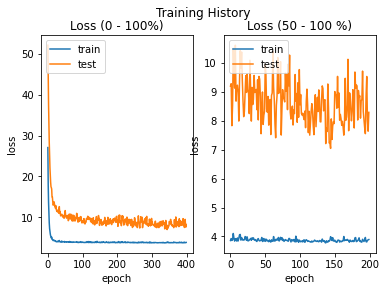

In [53]:
plotHistory(history_6)

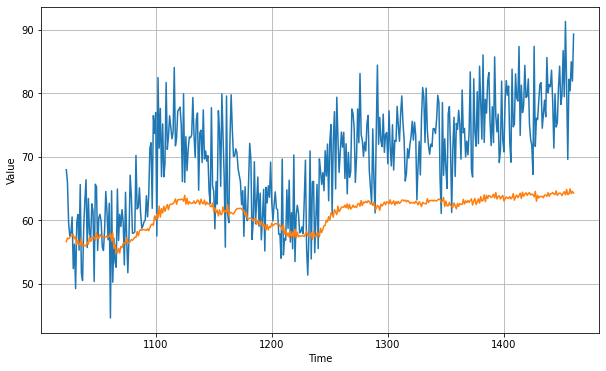

In [54]:
# Plot la prédiction
split_time = math.ceil(len(time) * (1 - ratio))
results = forecast(model_6, series, window_size, split_time)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

#### Conclusion

Malgré une prédiction de la slope toujours aussi problématique, le modèle prédit agit comme un passe-bas et filtre le bruit, ce qui a le mérite de réduire la mae.